# MOVIE STUDIO ANALYSIS

<img src="./moviedog.jpg" style="width:100%; height:auto;">

## Business Understanding

Our company have decided to create a new movie studio, but they don’t know anything about creating movies. We have been charged with exploring what types of films are currently doing the best at the box office. We must then translate the findings into actionable insights that the head of the company's new movie studio can use to help decide what type of films to create.

* Our focus will be to make suggestions for the type of movies that will be the most profitable for our new movie division.

## Data Understanding

We will be using the following datasets:

1. `rt.reviews.tsv` [from rotten tomatoes](https://www.rottentomatoes.com/)
2. `im.db` from [IMDB](https://www.imdb.com/)
3. `rt.movie_info.tsv`[from rotten tomatoes](https://www.rottentomatoes.com/)
4. `tn.movie_budgets.csv` from [NUMBERS](https://www.the-numbers.com/)

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

#### Loading Datasets

In [2]:
# reviews dataset
review_df = pd.read_csv('rt.reviews.tsv', sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
#review_df.head()

# bom.movie_gross.csv
movie_gross_df = pd.read_csv('bom.movie_gross.csv')
#movie_gross_df

# im.dbsqlite, we load only the 2 tables that are needed for the analysis. 
conn = sqlite3.connect('im.db')
q = '''
    SELECT *
    FROM movie_basics
    JOIN movie_ratings
    ON movie_basics.movie_ID = movie_ratings.movie_id
'''
imdb_df = pd.read_sql(q, conn)
imdb_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119
...,...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,tt9913084,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",tt9914286,8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5


In [3]:
# Loading 'The Numbers' Dataset 'tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv('tn.movie_budgets.csv')
movie_budgets_df.tail(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


In [4]:

movie_info_df = pd.read_csv('rt.movie_info.tsv',sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')

## Data Cleaning

#### 1.1 Merge review_df and Movie_df and clean the data

In [5]:
merged_df = pd.merge(review_df, movie_info_df, on='id', how='inner')


#### 1.2 Dropping columns from merged_df

In [6]:
# columns to drop
columns_to_drop =['review', 'critic', 'top_critic', 'publisher', 'synopsis', 'writer', 'studio']

merged_df = merged_df.drop(columns_to_drop, axis=1)


#### 1.3 Changing column names

In [7]:
merged_df = merged_df.rename(columns={'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'})
# # 2. Drop rows with missing values in specific columns
# merge_df.dropna(subset=['theater_date', 'dvd_date'], inplace=True)

# # 3. Impute missing values
# merge_df['runtime'].fillna(merge_df['runtime'].mean(), inplace=True)

# # 4. Fill with specific values
# merge_df['director'].fillna('Unknown', inplace=True)

In [8]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
merged_df

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,currency,box_office,runtime,standardized_rating
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,6.0
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54427,2000,NaN,fresh,"September 24, 2002",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,NaN
54428,2000,1/5,rotten,"September 21, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,2.0
54429,2000,2/5,rotten,"July 17, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,4.0
54430,2000,2.5/5,rotten,"September 7, 2003",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,5.0


#### 1.3 Checking and Dealing with Missing Values

In [9]:
merged_df.isna().sum()


id                         0
star_rating            13517
fresh                      0
date                       0
MPAA_rating               86
genre                     87
director                5440
theater_date            1226
dvd_date                1226
currency               21122
box_office             21122
runtime                  838
standardized_rating    13526
dtype: int64

In [10]:
merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean())
merged_df = merged_df.dropna(subset=['MPAA_rating', 'genre'])

In [11]:
# drop 'star_rating' column
merged_df.drop('star_rating', axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_8948\2815547901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop('star_rating', axis=1, inplace=True)


#### Checking and Dropping any Duplicates

In [12]:
duplicates = merged_df.duplicated().sum()
merged_df= merged_df.drop_duplicates()


In [13]:
# 1. Drop rows with missing values in specific columns
merged_df.dropna(subset=['theater_date', 'dvd_date'])

# 2. Fill with specific values
merged_df['director'].fillna('Unknown')

0        David Cronenberg
1        David Cronenberg
2        David Cronenberg
3        David Cronenberg
4        David Cronenberg
               ...       
54427             Unknown
54428             Unknown
54429             Unknown
54430             Unknown
54431             Unknown
Name: director, Length: 40407, dtype: object

In [14]:
# extract minutes in the runtime dataset
merged_df['runtime'] = merged_df['runtime'].str.extract('(\d+)').astype(float)

# fill the missing runtime values with the mean
merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_8948\3809561258.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)


### 2 Movie_budget_df

In [15]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### Check for Null Values

In [16]:
movie_budgets_df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### Check for Duplicates

In [17]:
movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [18]:
duplicated_rows = movie_budgets_df[movie_budgets_df.duplicated()]


### Imdb Dataset

In [19]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73856 non-null  object 
 7   averagerating    73856 non-null  float64
 8   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


#### Checking for Duplicates

In [20]:
duplicated_rows = imdb_df[imdb_df.duplicated]
duplicated_rows

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes


#### Checking and Dropping Nulls

In [21]:
imdb_df = imdb_df.dropna(subset = ['runtime_minutes', 'genres'])
imdb_df.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
movie_id           0
averagerating      0
numvotes           0
dtype: int64

## Univariate Analysis

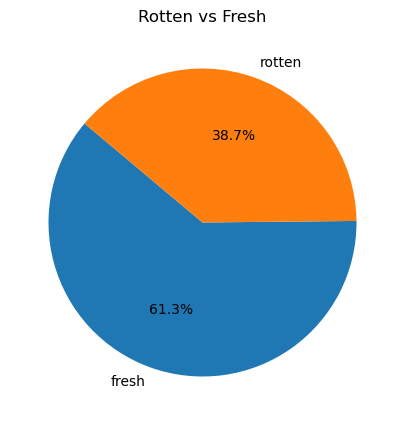

In [22]:
frequencies = merged_df['fresh'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 5))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=140)
plt.title('Rotten vs Fresh')
plt.show()

#### Converting Data Types

In [23]:
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Function to remove dollar signs and commas and convert to numeric
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

# Apply the function to the budget and gross columns
movie_budgets_df['production_budget'] = clean_currency(movie_budgets_df['production_budget'])
movie_budgets_df['domestic_gross'] = clean_currency(movie_budgets_df['domestic_gross'])
movie_budgets_df['worldwide_gross'] = clean_currency(movie_budgets_df['worldwide_gross'])

movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00


C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


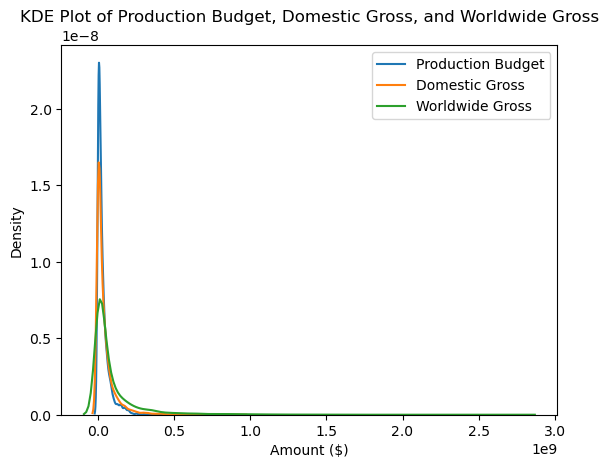

In [24]:
# kde plot of 'production_budget', 'domestic_gross', 'worldwide_gross'
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the KDE for each column
sns.kdeplot(data=movie_budgets_df, x='production_budget', ax=ax, label='Production Budget')
sns.kdeplot(data=movie_budgets_df, x='domestic_gross', ax=ax, label='Domestic Gross')
sns.kdeplot(data=movie_budgets_df, x='worldwide_gross', ax=ax, label='Worldwide Gross')

# Set the title and labels
ax.set_title('KDE Plot of Production Budget, Domestic Gross, and Worldwide Gross')
ax.set_xlabel('Amount ($)')
ax.set_ylabel('Density')

# Show the legend
ax.legend()

# Show the plot
plt.show()

### Imdb Analysis

#### Normalize and tokenize genre strings to analyze the combinations

In [25]:
# Normalize genre strings - making them of same of same category, lowecase
imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Expand genres into separate columns
genres_expanded = imdb_df['genres_list'].explode().unique()
for genre in genres_expanded:
    imdb_df[genre] = imdb_df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Drop the intermediate columns
df = imdb_df.drop(columns=['genres', 'genres_list'])

df.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_8948\2112896258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()
C:\Users\User\AppData\Local\Temp\ipykernel_8948\2112896258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_df['genres_list'] = imdb_df['genres'].str.split(',')
C:\Users\User\AppData\Local\Temp\ipykernel_8948\2112896258.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,movie_id,primary_title,original_title,start_year,runtime_minutes,movie_id,averagerating,numvotes,action,crime,...,war,music,sport,western,musical,news,reality-tv,game-show,adult,short
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,tt0063540,7.0,77,1,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,tt0066787,7.2,43,0,0,...,0,0,0,0,0,0,0,0,0,0


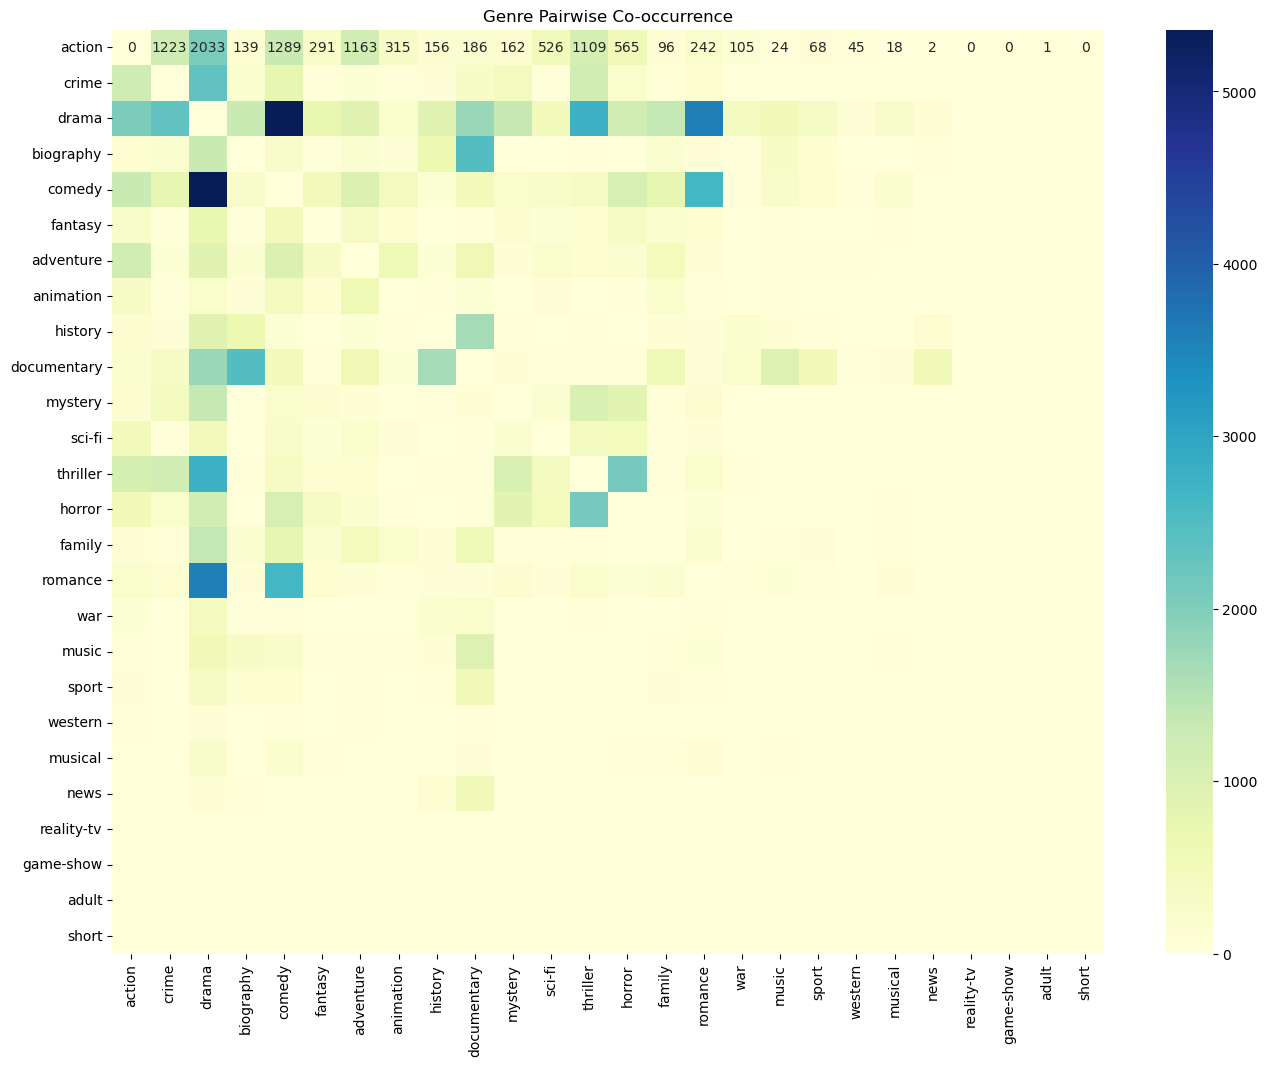

In [26]:
# Create a DataFrame for pairwise genre combinations
from itertools import combinations

# Calculate pairwise genre co-occurrence
genre_pairs = pd.DataFrame(
    index=genres_expanded,
    columns=genres_expanded,
    data=0
)

for genre1, genre2 in combinations(genres_expanded, 2):
    genre_pairs.loc[genre1, genre2] = ((imdb_df[genre1] & imdb_df[genre2]).sum())
    genre_pairs.loc[genre2, genre1] = genre_pairs.loc[genre1, genre2]

# Plot the pairwise co-occurrence
plt.figure(figsize=(16, 12))
sns.heatmap(genre_pairs, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre Pairwise Co-occurrence')
plt.show()

In [27]:
# Normalize genre strings
imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Create a DataFrame to store genre combinations
genre_combinations = pd.DataFrame(columns=['Combination', 'Count'])

# Generate genre combinations for each movie and count occurrences
combination_counts = {}

for _, row in imdb_df.iterrows():
    genres = sorted(row['genres_list'])  # Sort genres to ensure order consistency
    for r in range(1, len(genres) + 1):
        for combo in combinations(genres, r):
            combo_str = ' & '.join(combo)
            if combo_str in combination_counts:
                combination_counts[combo_str] += 1
            else:
                combination_counts[combo_str] = 1

# Convert the combination counts dictionary to a DataFrame
genre_combinations = pd.DataFrame(list(combination_counts.items()), columns=['Combination', 'Count'])

# Sort by Count in descending order
result_table = genre_combinations.sort_values(by='Count', ascending=False)

# Print the sorted table
print("Genre Combination Counts:")
print(result_table)

C:\Users\User\AppData\Local\Temp\ipykernel_8948\465517846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()
C:\Users\User\AppData\Local\Temp\ipykernel_8948\465517846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_df['genres_list'] = imdb_df['genres'].str.split(',')


Genre Combination Counts:
                          Combination  Count
2                               drama  28394
22                        documentary  16423
9                              comedy  15514
36                           thriller   7583
40                             horror   6917
..                                ...    ...
798             drama & war & western      1
800        adventure & music & sci-fi      1
802        biography & family & sport      1
804  action & animation & documentary      1
966     documentary & family & sci-fi      1

[967 rows x 2 columns]


#### Genre Frequency Distribution

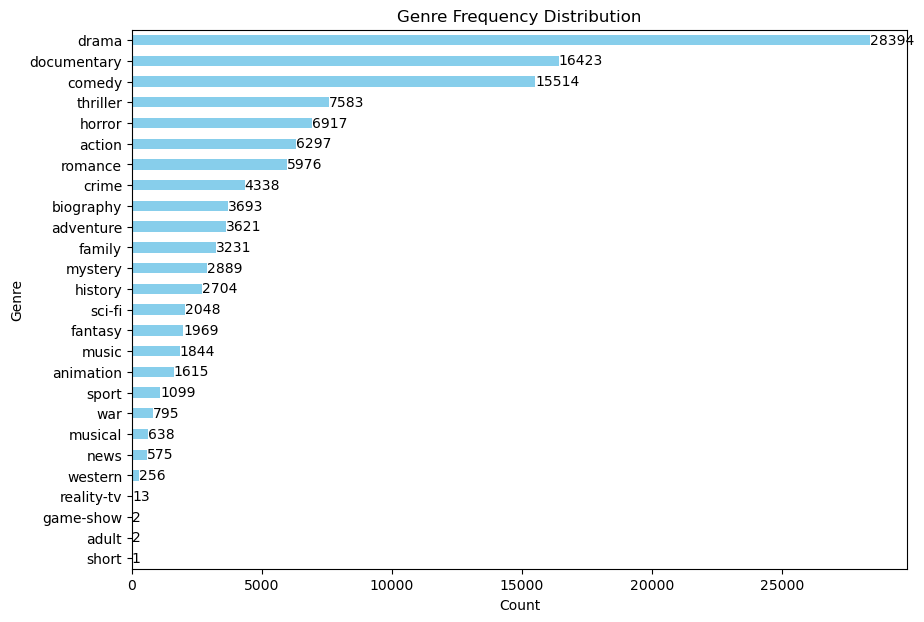

In [28]:
#Frequency count

# Count the frequency of each genre
genre_counts = df[genres_expanded].sum()

# Plot the distribution
plt.figure(figsize=(10, 7))
ax = genre_counts.sort_values().plot(kind='barh', color='skyblue')

# Add count labels next to each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, p.get_y() + p.get_height() / 2, int(width), 
            ha='left', va='center', color='black')

plt.title('Genre Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

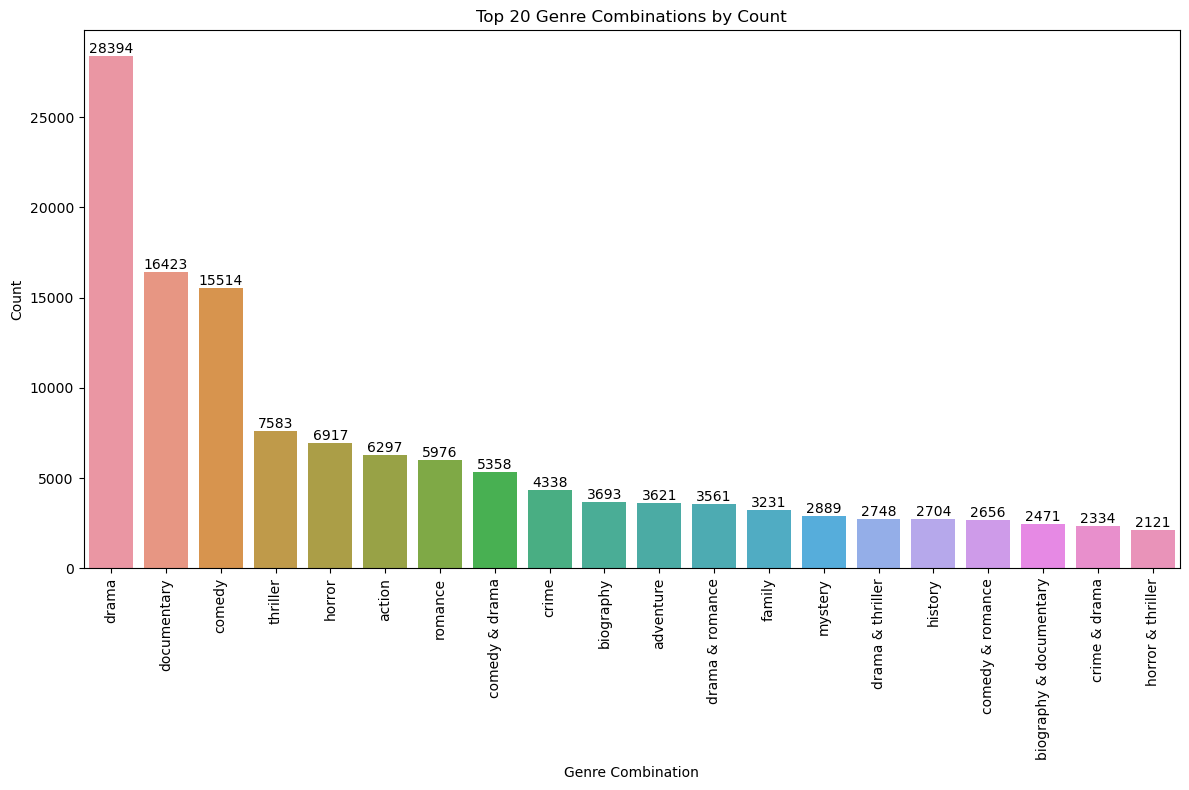

In [29]:
# Create DataFrame and select top 20 rows
result = pd.DataFrame(result_table)
result = result.head(20)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=result['Combination'], y=result['Count'])

# Adding annotations (count values) on top of each bar
for index, value in enumerate(result['Count']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Top 20 Genre Combinations by Count')
plt.xlabel('Genre Combination')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Movie_Budget Analysis

In [30]:
movie_budgets_df.head(2)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09


In [31]:
movie_budgets_df.describe()

,id,release_date,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,2004-07-06 05:20:31.546177792,3.158776e+07,4.187333e+07,9.148746e+07
min,1.000000,1915-02-08 00:00:00,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,2000-04-22 18:00:00,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,2007-03-02 00:00:00,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,2012-12-25 00:00:00,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,2020-12-31 00:00:00,4.250000e+08,9.366622e+08,2.776345e+09
std,28.821076,NaN,4.181208e+07,6.824060e+07,1.747200e+08


In [32]:
# Summary statistics
print(movie_budgets_df.describe())

                id                   release_date  production_budget  \
count  5782.000000                           5782       5.782000e+03   
mean     50.372363  2004-07-06 05:20:31.546177792       3.158776e+07   
min       1.000000            1915-02-08 00:00:00       1.100000e+03   
25%      25.000000            2000-04-22 18:00:00       5.000000e+06   
50%      50.000000            2007-03-02 00:00:00       1.700000e+07   
75%      75.000000            2012-12-25 00:00:00       4.000000e+07   
max     100.000000            2020-12-31 00:00:00       4.250000e+08   
std      28.821076                            NaN       4.181208e+07   

       domestic_gross  worldwide_gross  
count    5.782000e+03     5.782000e+03  
mean     4.187333e+07     9.148746e+07  
min      0.000000e+00     0.000000e+00  
25%      1.429534e+06     4.125415e+06  
50%      1.722594e+07     2.798445e+07  
75%      5.234866e+07     9.764584e+07  
max      9.366622e+08     2.776345e+09  
std      6.824060e+07  

In [33]:


# Correlation between budget and gross earnings
print(movie_budgets_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr())


                   production_budget  domestic_gross  worldwide_gross
production_budget           1.000000        0.685682         0.748306
domestic_gross              0.685682        1.000000         0.938853
worldwide_gross             0.748306        0.938853         1.000000


### Correlation Analysis:

#### 1. Production Budget vs Domestic Gross: 0.686
   - Moderately strong positive correlation
   - Higher budgets tend to yield higher domestic earnings

#### 2. Production Budget vs Worldwide Gross: 0.748
   - Stronger positive correlation than domestic
   - Big budgets have more impact on global earnings

#### 3. Domestic Gross vs Worldwide Gross: 0.939
   - Very strong positive correlation
   - Domestic success strongly indicates global success

### Key Insights from this analysis:

1. Budget Impact: Higher budgets are associated with higher earnings, both domestically and worldwide. The stronger correlation with worldwide gross suggests that big-budget movies might have more international appeal or marketing reach.
2. Domestic performance is a good predictor of global performance. Domestic-Worldwide relationship: The very strong correlation between domestic and worldwide gross implies that domestic performance is a good indicator of global performance. This could be due to factors like marketing strategies that work well across markets or the global influence of the US film market.
3. Budget isn't the only factor; While there's a positive correlation between budget and earnings, it's not perfect. This suggests that other factors (like quality, marketing, timing, etc.) play significant roles in a movie's financial success.
4. Worldwide potential: The stronger correlation between budget and worldwide gross (compared to domestic gross) might indicate that higher budgets are particularly beneficial for international appeal, perhaps due to more spectacular visual effects, bigger stars, or larger marketing campaigns that resonate globally.


#### Top Movie by Worldwide Gross

In [34]:
top_grossing = movie_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)
print(top_grossing[['movie', 'worldwide_gross']])

                                             movie  worldwide_gross
0                                           Avatar     2.776345e+09
42                                         Titanic     2.208208e+09
5             Star Wars Ep. VII: The Force Awakens     2.053311e+09
6                           Avengers: Infinity War     2.048134e+09
33                                  Jurassic World     1.648855e+09
66                                       Furious 7     1.518723e+09
26                                    The Avengers     1.517936e+09
3                          Avengers: Age of Ultron     1.403014e+09
41                                   Black Panther     1.348258e+09
260  Harry Potter and the Deathly Hallows: Part II     1.341693e+09


In [35]:
# Correlation between budget and gross earnings
print(movie_budgets_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr())

                   production_budget  domestic_gross  worldwide_gross
production_budget           1.000000        0.685682         0.748306
domestic_gross              0.685682        1.000000         0.938853
worldwide_gross             0.748306        0.938853         1.000000


#### Return on Investment

In [36]:
# Average budget and gross by year

# Function to clean currency and handle potential errors
def clean_currency(x):
    if isinstance(x, str):
        try:
            return float(x.replace('$', '').replace(',', ''))
        except ValueError:
            return np.nan
    return x if pd.notnull(x) else np.nan

# Clean the monetary columns
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency)
    movie_budgets_df[col] = pd.to_numeric(movie_budgets_df[col], errors='coerce')

# Convert release_date to datetime and extract the year
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year

# Calculate yearly averages
yearly_avg = movie_budgets_df.groupby('year')[columns_to_clean].mean()
print(yearly_avg)

      production_budget  domestic_gross  worldwide_gross
year                                                    
1915       1.100000e+05    1.000000e+07     1.100000e+07
1916       2.929535e+05    4.000000e+06     4.000000e+06
1920       1.000000e+05    3.000000e+06     3.000000e+06
1925       2.072500e+06    1.000000e+07     1.550000e+07
1927       2.000000e+06    0.000000e+00     0.000000e+00
...                 ...             ...              ...
2016       4.097370e+07    5.042387e+07     1.313614e+08
2017       5.003073e+07    6.222259e+07     1.692240e+08
2018       4.813886e+07    7.378870e+07     1.824786e+08
2019       5.273896e+07    4.280029e+07     9.965411e+07
2020       9.400000e+07    0.000000e+00     0.000000e+00

[96 rows x 3 columns]


In [37]:
top_grossing = movie_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)
top_grossing[['movie', 'worldwide_gross']]
movie_budgets_df['ROI'] = (movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']) / movie_budgets_df['production_budget']
top_roi = movie_budgets_df.sort_values('ROI', ascending=False).head(10)
print(top_roi[['movie', 'ROI']])

                         movie          ROI
5745               Deep Throat  1799.000000
5613                   Mad Max   497.750000
5492       Paranormal Activity   430.517853
5679               The Gallows   415.564740
5406   The Blair Witch Project   412.833333
5709             Super Size Me   341.058585
5346                     Bambi   311.354312
5773               El Mariachi   290.704000
5676  Night of the Living Dead   262.921614
5210                     Rocky   224.000000


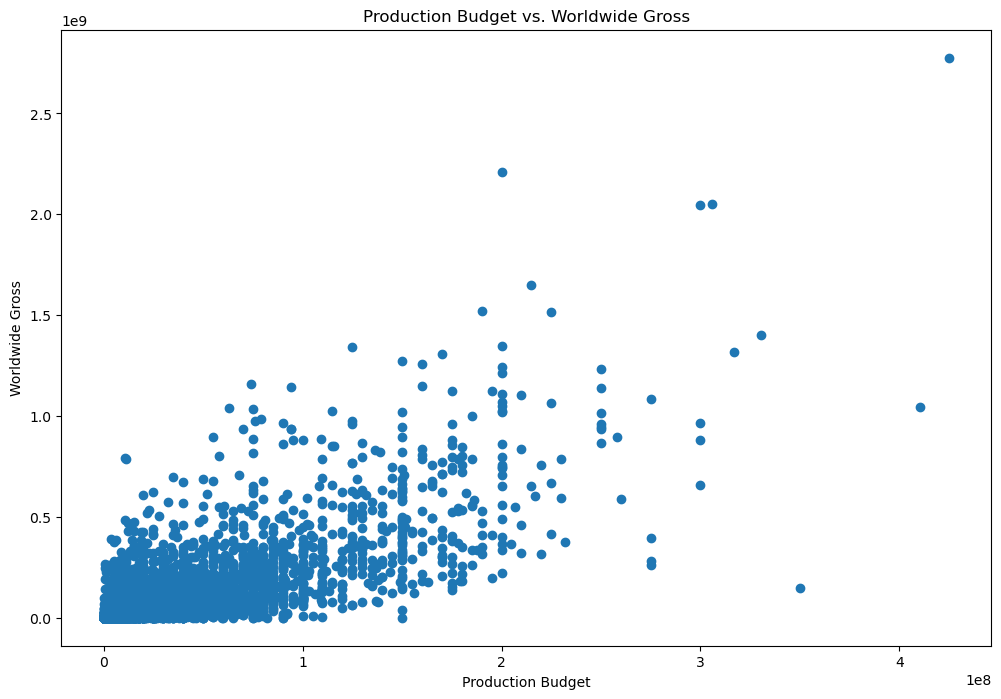

In [38]:
# visualize gross revenue vs budget using a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(movie_budgets_df['production_budget'], movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()

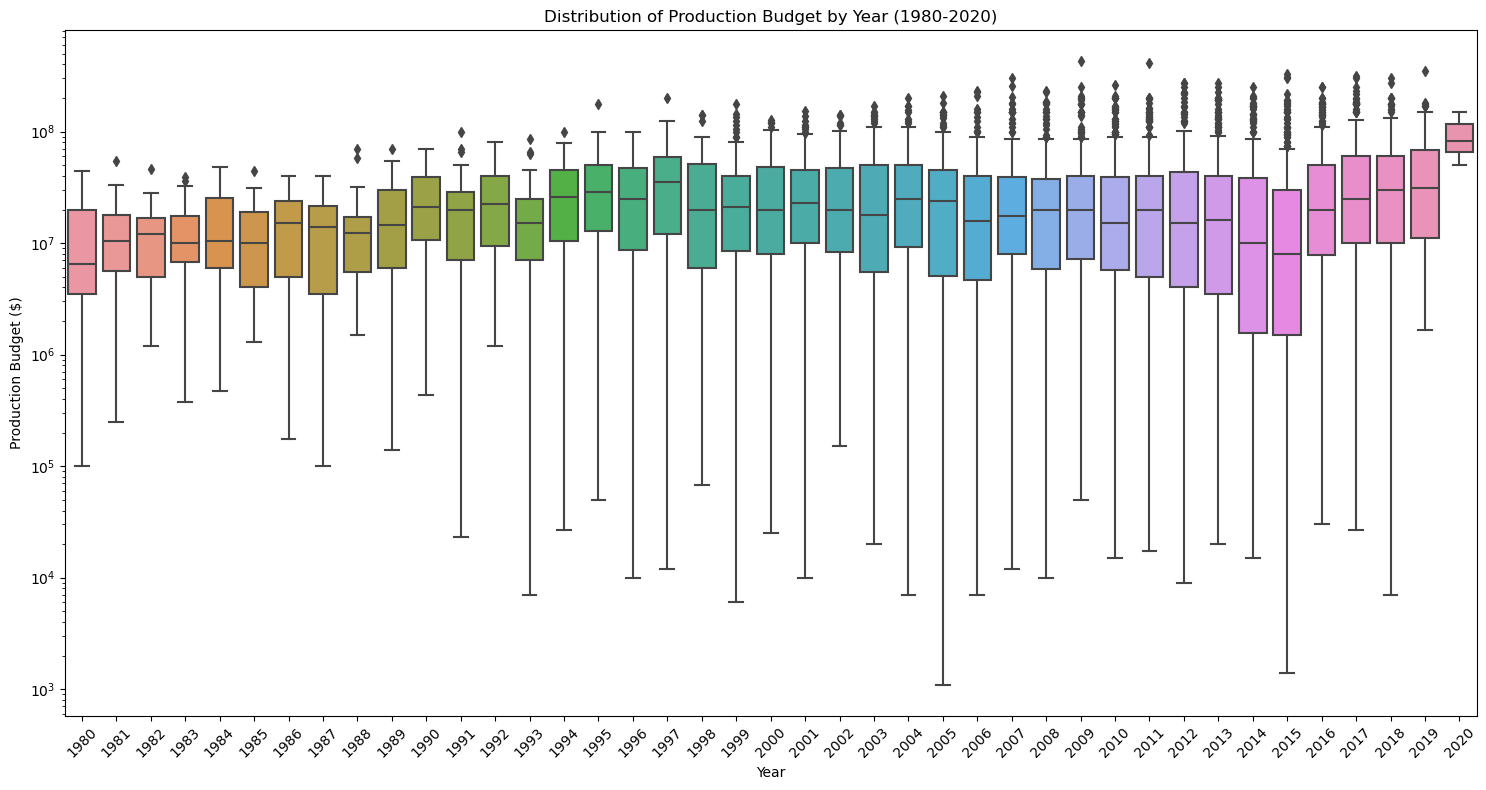

In [39]:
# Ensure the year and production_budget are in the correct format
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year
movie_budgets_df['production_budget'] = pd.to_numeric(movie_budgets_df['production_budget'], errors='coerce')

# Filter the dataframe for years 1980-2020
filtered_df = movie_budgets_df[(movie_budgets_df['year'] >= 1980) & (movie_budgets_df['year'] <= 2020)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='production_budget', data=filtered_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Production Budget ($)')
plt.title('Distribution of Production Budget by Year (1980-2020)')

# Use log scale for y-axis due to wide range of budget values
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


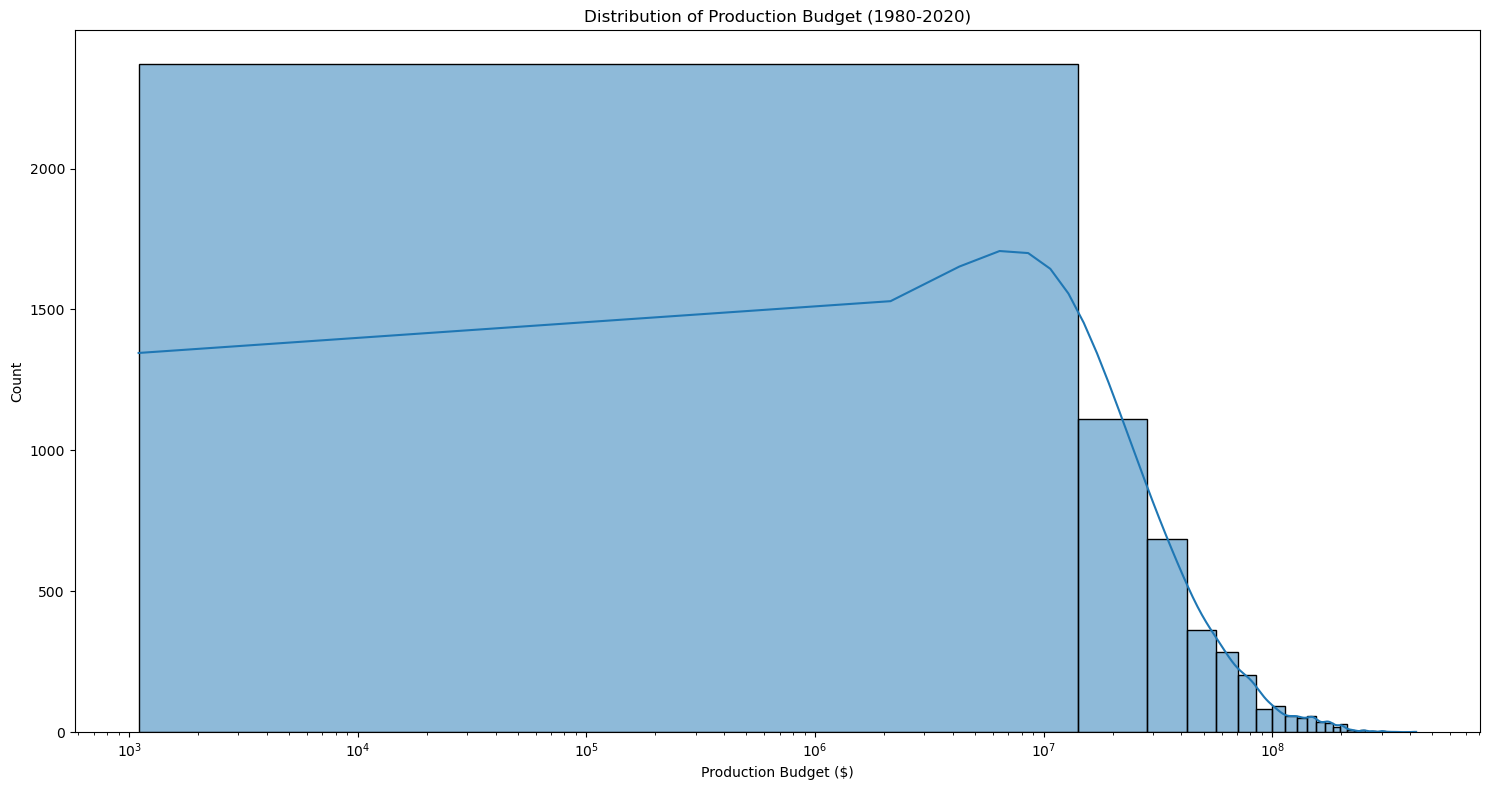

In [40]:
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year
movie_budgets_df['production_budget'] = pd.to_numeric(movie_budgets_df['production_budget'], errors='coerce')

# Filter the dataframe for years 1980-2020
filtered_df = movie_budgets_df[(movie_budgets_df['year'] >= 1980) & (movie_budgets_df['year'] <= 2020)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.histplot(data=filtered_df, x='production_budget', bins=30, kde=True)

# Set labels and title
plt.xlabel('Production Budget ($)')
plt.ylabel('Count')
plt.title('Distribution of Production Budget (1980-2020)')

# Use log scale for x-axis due to wide range of budget values
plt.xscale('log')

# Show the plot
plt.tight_layout()
plt.show()

#### Merged df Insights

In [41]:
merged_df.tail(2)

,id,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,currency,box_office,runtime,standardized_rating
54430,2000,rotten,"September 7, 2003",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94.0,5.0
54431,2000,fresh,"November 12, 2002",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94.0,6.0


In [42]:
merged_df.describe()

,id,runtime,standardized_rating
count,40407.000000,40407.000000,31515.000000
mean,1035.341376,109.922025,6.368556
std,581.664113,21.115137,2.171854
min,3.000000,52.000000,0.000000
25%,542.000000,96.000000,5.000000
50%,1069.000000,108.000000,6.250000
75%,1527.000000,119.000000,8.000000
max,2000.000000,358.000000,12.500000


#### Correlation between movie runtime and rating

In [43]:
corr = merged_df[['runtime', 'standardized_rating']].corr()
corr

,runtime,standardized_rating
runtime,1.000000,0.170877
standardized_rating,0.170877,1.000000


In [44]:
# Count occurrences of each genre
genre_counts = merged_df['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Calculate mean standardized rating for each genre
genre_ratings = merged_df.groupby('genre')['standardized_rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'mean_standardized_rating']

# Merge genre counts and mean standardized ratings
genre_summary = pd.merge(genre_counts, genre_ratings, on='genre')

# Count occurrences of each MPAA rating
mpaa_counts = merged_df['MPAA_rating'].value_counts().reset_index()
mpaa_counts.columns = ['MPAA_rating', 'count']

# Calculate average runtime for each MPAA rating
mpaa_runtime = merged_df.groupby('MPAA_rating')['runtime'].mean().reset_index()
mpaa_runtime.columns = ['MPAA_rating', 'average_runtime']

# Merge MPAA counts and average runtimes
mpaa_summary = pd.merge(mpaa_counts, mpaa_runtime, on='MPAA_rating')

print("Genre Summary:")
print(genre_summary)
print("\nMPAA Rating Summary:")
print(mpaa_summary)

Genre Summary:
                                                 genre  count  \
0                                                Drama   5826   
1                                               Comedy   3192   
2                                         Comedy|Drama   3059   
3                           Drama|Mystery and Suspense   2179   
4                                 Comedy|Drama|Romance   1354   
..                                                 ...    ...   
245  Art House and International|Classics|Comedy|Dr...      1   
246                                   Special Interest      1   
247                  Comedy|Kids and Family|Television      1   
248  Classics|Drama|Musical and Performing Arts|Mys...      1   
249  Art House and International|Drama|Mystery and ...      1   

     mean_standardized_rating  
0                    6.767306  
1                    5.324127  
2                    6.840373  
3                    6.484937  
4                    6.524585  
..          

#### The Best Director

In [45]:
# Group by director and calculate mean standardized rating and count of movies
director_stats = merged_df.groupby('director').agg({
    'standardized_rating': 'mean',
    'id': 'count'  # Assuming 'id' is unique for each movie
}).rename(columns={'id': 'movie_count'})

# Sort by mean rating in descending order
director_stats_sorted = director_stats.sort_values('standardized_rating', ascending=False)

# Display the top directors (you can adjust the number as needed)
print(director_stats_sorted.head(20))

                       standardized_rating  movie_count
director                                               
Alain Tanner                     10.000000            2
Orson Welles                      9.348485           58
Alexander Mackendrick             9.201613           43
Ingmar Bergman                    9.189394           53
Mitsuo Yanagimachi                9.166667            4
Yasujiro Ozu                      9.148148           31
Preston Sturges                   9.136364           17
Eric Rohmer                       9.125000            9
Dante Lam                         9.000000            5
Cheryl Dunye                      9.000000            1
Frank Capra                       8.750000           62
Jacques Tourneur                  8.750000            5
Blake Edwards                     8.750000            5
Joel Coen|Ethan Coen              8.731266          176
Anthony Mann                      8.708333           13
Marco Tullio Giordana             8.658537      

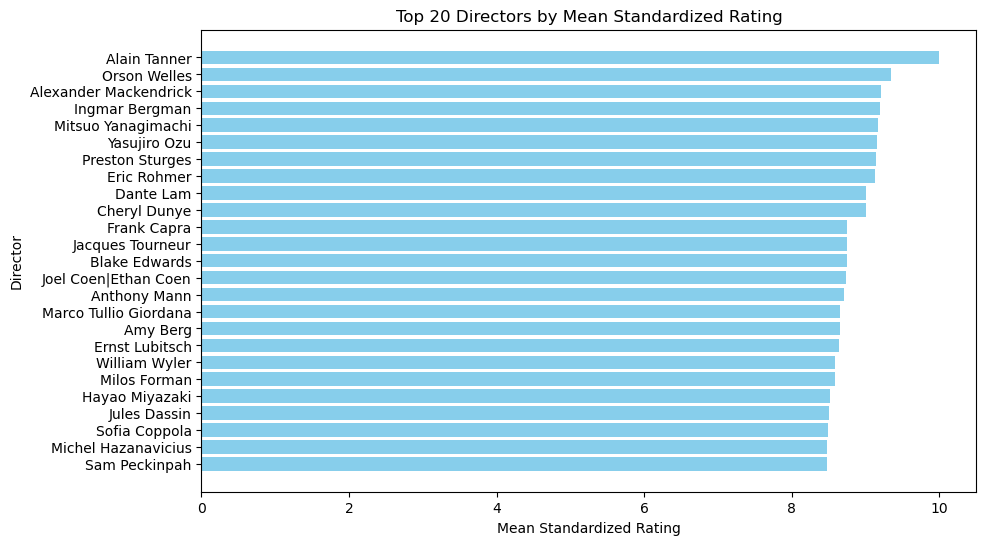

In [46]:
# Take the top 20 directors
top_directors = director_stats_sorted.head(25)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_directors.index, top_directors['standardized_rating'], color='skyblue')
plt.xlabel('Mean Standardized Rating')
plt.ylabel('Director')
plt.title('Top 20 Directors by Mean Standardized Rating')
plt.gca().invert_yaxis()  # To display the director with the highest rating at the top
plt.show()

C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


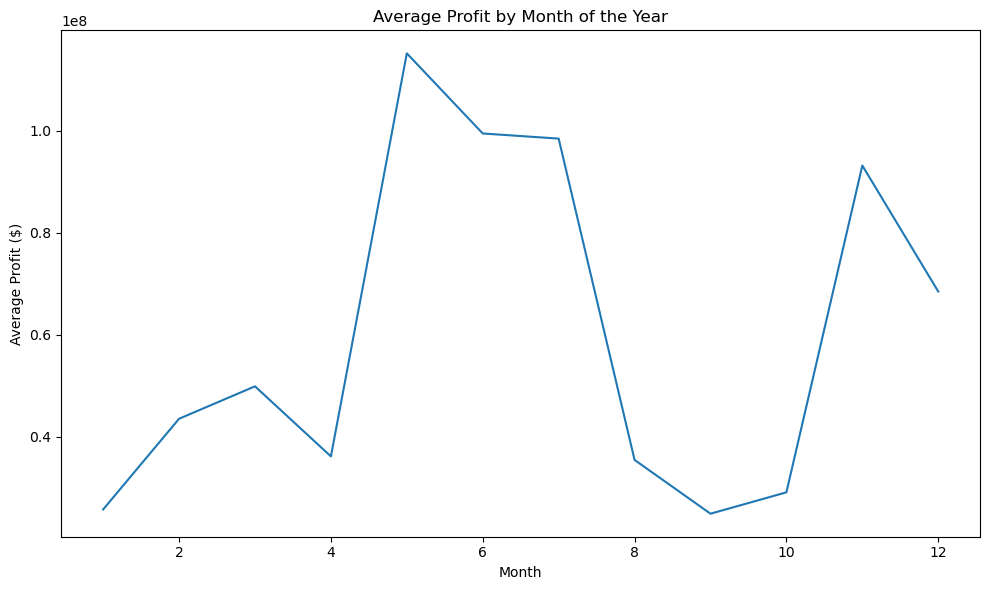

In [47]:
# Extract the month from the release_date column
movie_budgets_df['month'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.month

# Calculate the profit for each movie
movie_budgets_df['profit'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']

# Calculate the average profit by month
monthly_avg_profit = movie_budgets_df.groupby('month')['profit'].mean()

# Create the line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg_profit.index, y=monthly_avg_profit.values)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Profit by Month of the Year')

# Show the plot
plt.tight_layout()
plt.show()

# CONCLUSION AND RECOMMENDATIONS

### 1. Best movies genre for Production

* *Drama* : Based on our data it is highly evident that the drama category is the most popular among viewers with a significantly high number of occurences ie `28394` and a high mean standard rating ie `6.663` compared to the 2nd most popular category, comedy with a occurence `15514` and mean of `5.546` meaning drama category is more appealing and engaging to a higher audience.
* *Mixed Genres* : in Movies that combine genres, it is evident that the combination for Comedy & Drama, have high a high occurrence of `5358` and rating of `6.742` indicating a successful formula/combination. This shows that movies that blend elements of both comedy and drama are more apealing to a lerger audience. These film offer the best of both worlds providing viewers with a balanced mix of humor and eotional depth.

### 2. Average production budget

* It is noted that the average production budget for the movies over the years is `$ 31 million` with an average domestic and world_wide revenue of `$ 41 million` and `$ 91 million` respectively.

* Thre is a moderately strong positive correlation between production budget and domestic gross at `0.686`.

* There is a strong positive correlation between prodction budget and worl-wide gross at `0.748`, implying that high budgets have more impact on global earnings, which may reflect in quality directors, advertisemnts, actors.

* There is also a very `strong positive correlation` between domestic gross and worldwide gross at `0.939`, implying that if a movie succeeds domestically, it will succeed globally.

### 3.Movie length

* From the Findings, there is a very low `positive correlation` of `0.15` between movie length and the critic-rating, implying that as the movie runtime increases, there is slight tendency for critic rating to increase as well but the relationship is not strong.

### 4. Recommended director to hire

* The Coen brothers ie Joen Coen and Ethan Coen have directed `176` movies with a rating of `8.105`. This indicates that they are highly respected fil makers with a strong track record of producing quality films.
* The next recommended director is Sofia Coppola whose movies have a rating of `8.052129` having directed `169` movies. Her high average rating is essentionally high which suggests that her movies are consistently well received by critics and audiences alike.

### 5. Release Date

In [ ]:
* Based on the analysis of the average profit by month of the year, it appears that May, June, and July are the most profitable months for movies. May has an average profit of 11.5 million followed closely by June with 10 million and July with 9.8 million. This could be due to a variety of factors, such as the release of popular blockbusters during these months, favorable weather conditions, or the end of the school year leading to increased attendance.